In [435]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE

In [436]:
decision = pd.read_csv(r'dados_ciclo_basic\decision.csv.csv')
results = pd.read_csv(r'dados_ciclo_basic\FIFA Results.csv')
penal = pd.read_csv(r'dados_ciclo_basic\penality kick.csv.csv')
rank = pd.read_csv(r'dados_ciclo_basic\Fifa_ranking_2022-10-06.csv')
dados_copa = pd.read_csv(r'dados_ciclo_basic\world_cup.csv')
match_results = pd.read_csv(r'dados_ciclo_basic\matches_1930_2022.csv')


In [437]:
match_results = match_results.rename(columns={'Date': 'date'})

match_results['date'] = pd.to_datetime(match_results['date'])
decision['date'] = pd.to_datetime(decision['date'])

merged_df = pd.merge(
    match_results,
    decision,
    on=['date', 'home_team', 'away_team', 'home_score', 'away_score'],
    how='left'  
)


In [438]:
merged_df['date'] = pd.to_datetime(merged_df['date'])
merged_df['year'] = merged_df['date'].dt.year

home_df = merged_df[[
    'home_team', 'away_team', 'home_score', 'away_score',
    'home_xg', 'away_xg', 'year'
]].copy()
home_df.columns = ['team', 'opponent', 'goals_for', 'goals_against', 'xg_for', 'xg_against', 'year']

away_df = merged_df[[
    'away_team', 'home_team', 'away_score', 'home_score',
    'away_xg', 'home_xg', 'year'
]].copy()
away_df.columns = ['team', 'opponent', 'goals_for', 'goals_against', 'xg_for', 'xg_against', 'year']

long_df = pd.concat([home_df, away_df], ignore_index=True)

team_stats = long_df.groupby(['team', 'year']).agg({
    'goals_for': 'sum',
    'goals_against': 'sum',
    'xg_for': 'sum',
    'xg_against': 'sum',
    'opponent': 'count'  # número de jogos
}).rename(columns={'opponent': 'matches'}).reset_index()


In [439]:
match_results = match_results.rename(columns={'Year': 'year'})

In [440]:
home_results = match_results[['home_team', 'home_score', 'away_score', 'year']].copy()
home_results.rename(columns={'home_team':'team', 'home_score':'goals_for', 'away_score':'goals_against'}, inplace=True)

away_results = match_results[['away_team', 'away_score', 'home_score', 'year']].copy()
away_results.rename(columns={'away_team':'team', 'away_score':'goals_for', 'home_score':'goals_against'}, inplace=True)

all_results = pd.concat([home_results, away_results], ignore_index=True)

def get_result(row):
    if row['goals_for'] > row['goals_against']:
        return 'win'
    elif row['goals_for'] == row['goals_against']:
        return 'draw'
    else:
        return 'loss'

all_results['result'] = all_results.apply(get_result, axis=1)

stats = all_results.groupby(['team', 'year'])['result'].value_counts().unstack(fill_value=0)

stats['matches'] = stats.sum(axis=1)
stats['win_rate'] = stats['win'] / stats['matches']

print(stats.head())

team_stats = team_stats.merge(stats[['matches', 'win', 'draw', 'win_rate']], on=['team', 'year'], how='left')


result        draw  loss  win  matches  win_rate
team    year                                    
Algeria 1982     0     1    2        3  0.666667
        1986     1     2    0        3  0.000000
        2010     1     2    0        3  0.000000
        2014     1     2    1        4  0.250000
Angola  2006     2     1    0        3  0.000000


In [441]:
team_stats = team_stats.merge(
    dados_copa[['Year', 'Champion']],
    left_on='year',
    right_on='Year',
    how='left'
)

team_stats['champion'] = (team_stats['team'] == team_stats['Champion']).astype(int)

team_stats.drop(columns=['Champion', 'Year'], inplace=True)

team_stats.head()

,team,year,goals_for,goals_against,xg_for,xg_against,matches_x,matches_y,win,draw,win_rate,champion
0,Algeria,1982,5,5,0.0,0.0,3,3,2,0,0.666667,0
1,Algeria,1986,1,5,0.0,0.0,3,3,0,1,0.000000,0
2,Algeria,2010,0,2,0.0,0.0,3,3,0,1,0.000000,0
3,Algeria,2014,7,7,0.0,0.0,4,4,1,1,0.250000,0
4,Angola,2006,1,2,0.0,0.0,3,3,0,2,0.000000,0


In [442]:
team_stats = team_stats.merge(
    dados_copa[['Year', 'Host']],
    left_on='year',
    right_on='Year',
    how='left'
)
team_stats.drop(columns='Year', inplace=True)

print(team_stats[['team', 'year', 'Host']].drop_duplicates().sort_values('year'))

              team  year     Host
5        Argentina  1930  Uruguay
50         Bolivia  1930  Uruguay
444  United States  1930  Uruguay
54          Brazil  1930  Uruguay
93           Chile  1930  Uruguay
..             ...   ...      ...
439        Tunisia  2022    Qatar
28       Australia  2022    Qatar
454  United States  2022    Qatar
468        Uruguay  2022    Qatar
22       Argentina  2022    Qatar

[489 rows x 3 columns]


In [443]:
team_stats['matches'] = team_stats['matches_y']

team_stats.drop(columns=['matches_x', 'matches_y'], inplace=True)

In [444]:
decision['date'] = pd.to_datetime(decision['date'])
decision['year'] = decision['date'].dt.year

home_d = decision[['home_team', 'away_team', 'tournament', 'city', 'country', 'neutral', 'year']].copy()
home_d.columns = ['team', 'opponent', 'tournament', 'city', 'country', 'neutral', 'year']

away_d = decision[['away_team', 'home_team', 'tournament', 'city', 'country', 'neutral', 'year']].copy()
away_d.columns = ['team', 'opponent', 'tournament', 'city', 'country', 'neutral', 'year']

decision_long = pd.concat([home_d, away_d], ignore_index=True)

decision_agg = decision_long.groupby(['team', 'year']).agg({
    'neutral': 'mean',         # % de jogos em campo neutro
    'tournament': lambda x: x.mode().iloc[0] if not x.mode().empty else None,
    'country': lambda x: x.mode().iloc[0] if not x.mode().empty else None,
}).reset_index()

decision_agg.rename(columns={'neutral': 'pct_neutral_games'}, inplace=True)

In [445]:
team_stats['goal_difference'] = team_stats['goals_for'] - team_stats['goals_against']
team_stats['avg_goals_for'] = team_stats['goals_for'] / team_stats['matches']
team_stats['avg_xg_for'] = team_stats['xg_for'] / team_stats['matches']


In [446]:
team_stats = team_stats.merge(
    decision_agg,
    on=['team', 'year'],
    how='left'
)

In [447]:
team_stats = team_stats.merge(
    rank[['team', 'rank', 'points']],
    on='team',
    how='left'
)

In [448]:
team_stats = team_stats.drop(columns=['country'])

In [449]:
team_stats = team_stats[
    team_stats['tournament'].isin(['FIFA World Cup qualification', 'FIFA World Cup'])
].copy()
team_stats['is_host'] = (team_stats['team'] == team_stats['Host']).astype(int)

# Exemplo completo

# 1. Extrair times que jogaram a Copa de 2022 a partir do DataFrame 'decision'
# Ajuste "World Cup" para "Copa do Mundo" se necessário:
worldcup_2022_teams = pd.concat([
    decision[(decision['year'] == 2022) & (decision['tournament'].str.contains("World Cup", case=False))]['home_team'],
    decision[(decision['year'] == 2022) & (decision['tournament'].str.contains("World Cup", case=False))]['away_team']
]).unique()

# 2. Filtrar 'team_stats' para que contenha apenas os times participantes
team_stats = team_stats[team_stats['team'].isin(worldcup_2022_teams)]

In [450]:
team_stats['avg_goals_against'] = team_stats['goals_against'] / team_stats['matches']
team_stats['avg_goal_difference'] = team_stats['goal_difference'] / team_stats['matches']
team_stats['goal_ratio'] = team_stats['goals_for'] / (team_stats['goals_against'] + 1e-5)
team_stats['xg_difference'] = team_stats['xg_for'] - team_stats['xg_against']

features = [
    'goals_for', 'goals_against', 'win', 'draw', 'win_rate',
    'goal_difference', 'avg_goals_for', 'avg_goals_against',
    'avg_goal_difference', 'goal_ratio', 'xg_for', 'xg_against', 'xg_difference',
    'pct_neutral_games', 'rank', 'points', 
    'is_host'
]

for col in features:
    median = team_stats[col].median()
    team_stats[col] = team_stats[col].fillna(median)

team_stats = team_stats.dropna(subset=['champion'])

X = team_stats[features]
y = team_stats['champion']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Balanceamento com SMOTE
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train_scaled, y_train)

model = RandomForestClassifier(
    n_estimators=300,
    max_depth=5,
    random_state=42,
    min_samples_split=10,
)

model.fit(X_train_bal, y_train_bal)
y_pred = model.predict(X_test_scaled)

print("=== Relatório de Classificação (Teste) ===")
print(classification_report(y_test, y_pred))


=== Relatório de Classificação (Teste) ===
              precision    recall  f1-score   support

           0       1.00      0.96      0.98        23
           1       0.75      1.00      0.86         3

    accuracy                           0.96        26
   macro avg       0.88      0.98      0.92        26
weighted avg       0.97      0.96      0.96        26



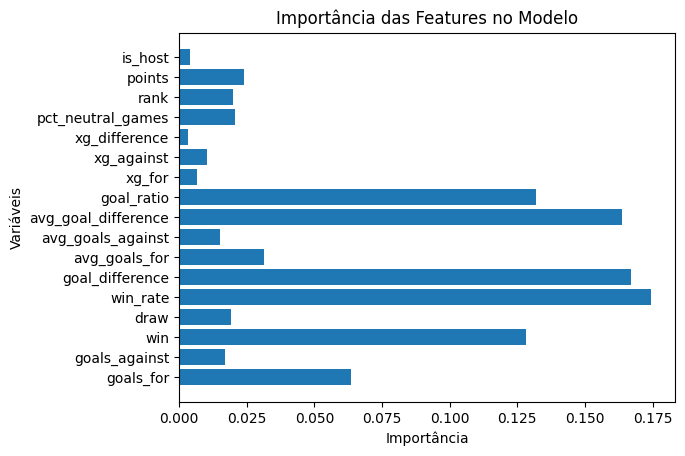

In [451]:
importances = model.feature_importances_
plt.barh(features, importances)
plt.xlabel("Importância")
plt.ylabel("Variáveis")
plt.title("Importância das Features no Modelo")
plt.show()

=== Relatório de Classificação (Teste) ===
              precision    recall  f1-score   support

           0       1.00      0.85      0.92        34
           1       0.50      1.00      0.67         5

    accuracy                           0.87        39
   macro avg       0.75      0.93      0.79        39
weighted avg       0.94      0.87      0.89        39


=== Importância das Features ===
goal_difference        0.190388
win                    0.172733
avg_goal_difference    0.144880
goal_ratio             0.131329
goals_for              0.110181
win_rate               0.067000
avg_goals_for          0.044131
avg_goals_against      0.025629
rank                   0.022857
pct_neutral_games      0.021309
points                 0.019102
goals_against          0.018495
xg_against             0.011831
draw                   0.010629
xg_for                 0.005685
is_host                0.003148
xg_difference          0.000671
dtype: float64


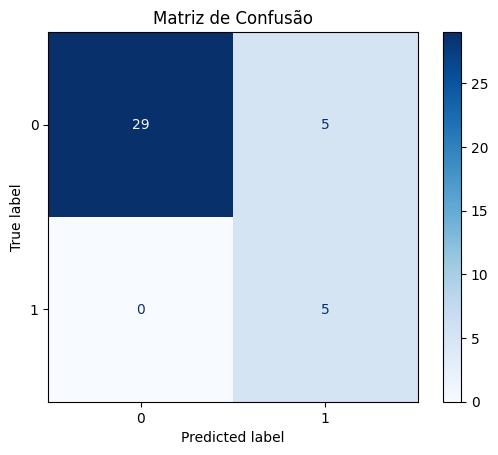

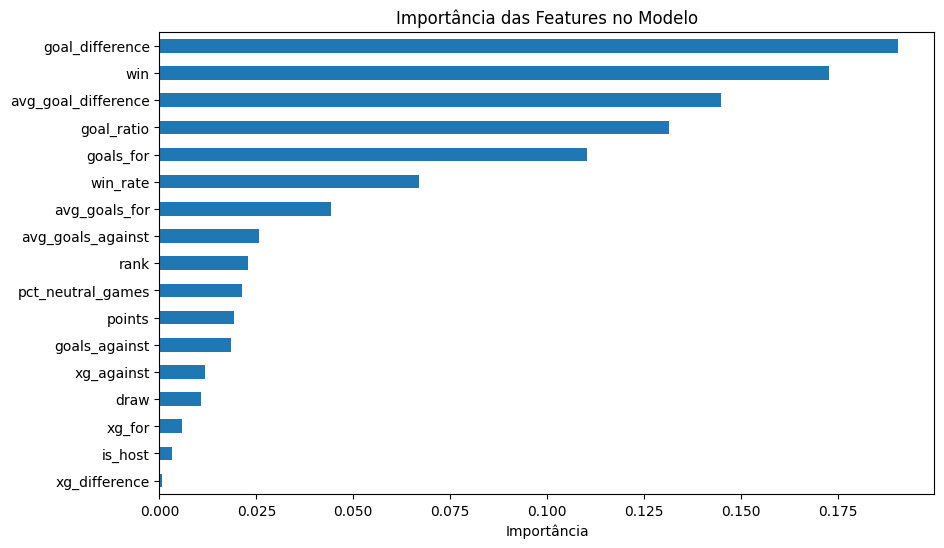

In [452]:
features = [
    'goals_for', 'goals_against', 'win', 'draw', 'win_rate',
    'goal_difference', 'avg_goals_for', 'avg_goals_against',
    'avg_goal_difference', 'goal_ratio', 'xg_for', 'xg_against', 'xg_difference',
    'pct_neutral_games', 'rank', 'points', 
    'is_host'
]

for col in features:
    median = team_stats[col].median()
    team_stats[col] = team_stats[col].fillna(median)

team_stats = team_stats.dropna(subset=['champion'])


X = team_stats[features]
y = team_stats['champion']  

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Padronização dos dados
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Balanceamento com SMOTE
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train_scaled, y_train)

# Treinamento do modelo com os melhores hiperparâmetros
model = RandomForestClassifier(
    n_estimators=300,
    max_depth=5,
    min_samples_split=10,
    random_state=42
)
model.fit(X_train_bal, y_train_bal)

y_pred = model.predict(X_test_scaled)
print("=== Relatório de Classificação (Teste) ===")
print(classification_report(y_test, y_pred))

importances = model.feature_importances_
importance_series = pd.Series(importances, index=features).sort_values(ascending=False)
print("\n=== Importância das Features ===")
print(importance_series)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap=plt.cm.Blues)  
plt.title("Matriz de Confusão")
plt.show()

plt.figure(figsize=(10, 6))
importance_series.plot(kind='barh')
plt.xlabel("Importância")
plt.title("Importância das Features no Modelo")
plt.gca().invert_yaxis() 
plt.show()


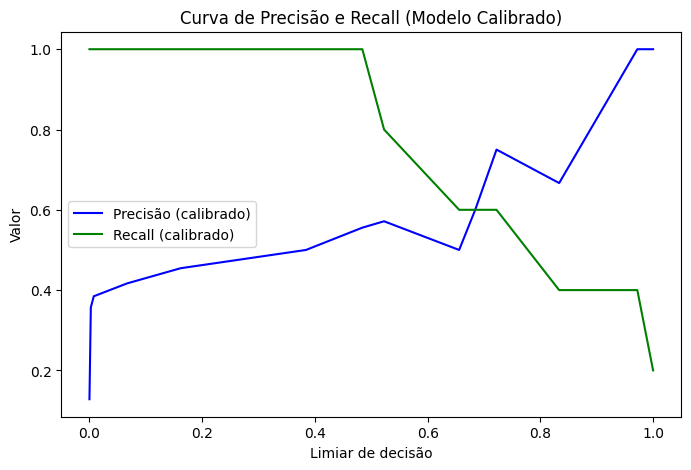

[[31  3]
 [ 2  3]]
              precision    recall  f1-score   support

           0       0.94      0.91      0.93        34
           1       0.50      0.60      0.55         5

    accuracy                           0.87        39
   macro avg       0.72      0.76      0.74        39
weighted avg       0.88      0.87      0.88        39



In [453]:
from sklearn.calibration import CalibratedClassifierCV

# Calibrar o modelo usando o parâmetro 'estimator'
calibrated_model = CalibratedClassifierCV(estimator=model, cv=3, method='isotonic')
calibrated_model.fit(X_train_scaled, y_train)

# Gerar as probabilidades calibradas para o conjunto de teste
y_probas_calibradas = calibrated_model.predict_proba(X_test_scaled)[:, 1]

# Agora, vamos gerar a curva Precision-Recall para ver o comportamento das probabilidades calibradas
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, confusion_matrix, classification_report

precisions_cal, recalls_cal, thresholds_cal = precision_recall_curve(y_test, y_probas_calibradas)
plt.figure(figsize=(8,5))
plt.plot(thresholds_cal, precisions_cal[:-1], label="Precisão (calibrado)", color="blue")
plt.plot(thresholds_cal, recalls_cal[:-1], label="Recall (calibrado)", color="green")
plt.xlabel("Limiar de decisão")
plt.ylabel("Valor")
plt.title("Curva de Precisão e Recall (Modelo Calibrado)")
plt.legend()
plt.show()

# Ajuste do limiar, experimente um valor (por exemplo, 0.60)
limiar_otimo_cal = 0.60  
y_pred_calibrado = (y_probas_calibradas >= limiar_otimo_cal).astype(int)

print(confusion_matrix(y_test, y_pred_calibrado))
print(classification_report(y_test, y_pred_calibrado))

In [454]:
team_stats['avg_goals_against']   = team_stats['goals_against'] / team_stats['matches']
team_stats['avg_goal_difference'] = team_stats['goal_difference'] / team_stats['matches']
team_stats['goal_ratio']          = team_stats['goals_for'] / (team_stats['goals_against'] + 1e-5)
team_stats['xg_difference']       = team_stats['xg_for'] - team_stats['xg_against']

features = [
    'goals_for', 'goals_against', 'win', 'draw', 'win_rate',
    'goal_difference', 'avg_goals_for', 'avg_goals_against',
    'avg_goal_difference', 'goal_ratio', 'xg_for', 'xg_against', 'xg_difference',
    'pct_neutral_games', 'rank', 'points', 
    'is_host'
]

for col in features:
    median = team_stats[col].median()
    team_stats[col] = team_stats[col].fillna(median)

team_stats = team_stats.dropna(subset=['champion'])

X_new = team_stats[features]

X_new_scaled = scaler.transform(X_new)

champion_proba = model.predict_proba(X_new_scaled)[:, 1]

team_stats['champion_probability'] = champion_proba

teams_ordered = team_stats.sort_values('champion_probability', ascending=False)

aggregated_ranking = team_stats.groupby('team')['champion_probability'].mean().sort_values(ascending=False)

print("Ranking das seleções com base na probabilidade de ser campeão (individual):")
print(teams_ordered[['team', 'champion_probability']])
print("\nRanking agregado por seleção:")
print(aggregated_ranking)

Ranking das seleções com base na probabilidade de ser campeão (individual):
              team  champion_probability
13       Argentina              0.958460
239          Italy              0.936636
181         France              0.849041
225          Italy              0.835000
60          Brazil              0.833670
..             ...                   ...
336       Portugal              0.000000
445  United States              0.000000
413         Sweden              0.000000
414         Sweden              0.000000
424    Switzerland              0.000000

[129 rows x 2 columns]

Ranking agregado por seleção:
team
France           0.490739
Netherlands      0.458194
Germany          0.440951
Brazil           0.375665
Colombia         0.369704
Italy            0.319894
Argentina        0.313534
Uruguay          0.270416
Portugal         0.192309
Croatia          0.167564
Spain            0.123811
Poland           0.078473
Belgium          0.071884
England          0.029405
Sweden  

=== Relatório de Classificação (Teste) ===
              precision    recall  f1-score   support

           0       0.97      0.88      0.92        34
           1       0.50      0.80      0.62         5

    accuracy                           0.87        39
   macro avg       0.73      0.84      0.77        39
weighted avg       0.91      0.87      0.88        39



c:\Users\VICTUS\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:48:13] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


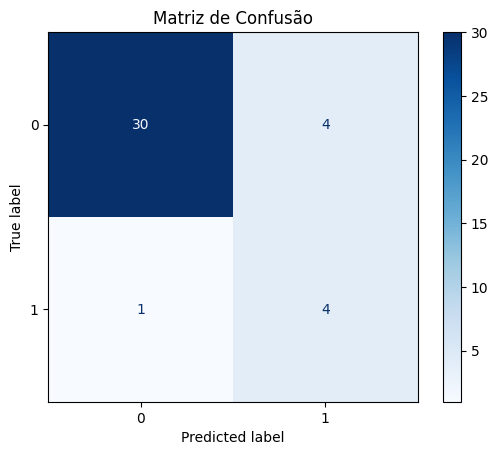


Ranking das seleções (por registro individual):
          team  champion_probability
13   Argentina              0.999368
176     France              0.997151
404      Spain              0.996481
235      Italy              0.993607
181     France              0.989480
..         ...                   ...
410     Sweden              0.000498
150    England              0.000450
151    England              0.000431
44     Belgium              0.000418
58      Brazil              0.000381

[129 rows x 2 columns]


In [455]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

# ===============================
# 1. Preparação e Feature Engineering
# ===============================
# Calcular novas features
team_stats['avg_goals_against']   = team_stats['goals_against'] / team_stats['matches']
team_stats['avg_goal_difference'] = team_stats['goal_difference'] / team_stats['matches']
team_stats['goal_ratio']          = team_stats['goals_for'] / (team_stats['goals_against'] + 1e-5)
team_stats['xg_difference']       = team_stats['xg_for'] - team_stats['xg_against']

# Lista de features a utilizar na modelagem
features = [
    'goals_for', 'goals_against', 'win', 'draw', 'win_rate',
    'goal_difference', 'avg_goals_for', 'avg_goals_against',
    'avg_goal_difference', 'goal_ratio', 'xg_for', 'xg_against', 'xg_difference',
    'pct_neutral_games', 'rank', 'points', 
    'is_host'
]

# Preencher valores ausentes com a mediana para cada feature
for col in features:
    median = team_stats[col].median()
    team_stats[col] = team_stats[col].fillna(median)

# Remover linhas sem rótulo na coluna 'champion'
team_stats = team_stats.dropna(subset=['champion'])

# ===============================
# 2. Separação e Pré-processamento dos Dados
# ===============================
X = team_stats[features]
y = team_stats['champion']   # Supondo que 'champion' seja booleano (True para campeão, False para não)

# Dividir em treino e teste (usando stratificação para manter a proporção de campeões)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Padronização dos dados
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ===============================
# 3. Treinamento do Modelo XGBoost
# ===============================
# Para lidar com desbalanceamento, ajustamos scale_pos_weight:
# scale_pos_weight = (número de amostras negativas) / (número de amostras positivas)
scale_pos_weight = (len(y_train) - y_train.sum()) / y_train.sum()

# Inicializar e treinar o XGBoost
model = XGBClassifier(
    n_estimators=300,
    max_depth=5,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'  # evita warning de label encoder
)
model.fit(X_train_scaled, y_train)

# Fazer predições e exibir o relatório de classificação
y_pred = model.predict(X_test_scaled)
print("=== Relatório de Classificação (Teste) ===")
print(classification_report(y_test, y_pred))

# ===============================
# 4. Previsão de Probabilidade e Ranking
# ===============================
# Para previsão, utilizamos os mesmos dados (ou dados atuais/futuros dos times participantes)
# Seleciona os dados de features para previsão
X_new = team_stats[features]
X_new_scaled = scaler.transform(X_new)

# Obter a probabilidade da classe 'campeão' (classe 1)
champion_proba = model.predict_proba(X_new_scaled)[:, 1]

# Adicionar a probabilidade ao DataFrame
team_stats['champion_probability'] = champion_proba

# Ordenar individualmente as linhas por probabilidade (se houver múltiplos registros por seleção)
teams_ordered = team_stats.sort_values('champion_probability', ascending=False)

# Se houver registros duplicados de uma mesma seleção, podemos agrupar e calcular a média
aggregated_ranking = team_stats.groupby('team')['champion_probability'].mean().sort_values(ascending=False)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap=plt.cm.Blues)  # Você pode alterar o cmap, como 'viridis' ou outro
plt.title("Matriz de Confusão")
plt.show()

# Exibir resultados
print("\nRanking das seleções (por registro individual):")
print(teams_ordered[['team', 'champion_probability']])


In [456]:
print("\nRanking agregado por seleção:")
print(aggregated_ranking)


Ranking agregado por seleção:
team
Colombia         0.472265
France           0.448000
Germany          0.397269
Italy            0.375730
Uruguay          0.333934
Brazil           0.316674
Netherlands      0.288751
Argentina        0.218600
Spain            0.127020
Portugal         0.044153
Poland           0.043270
Belgium          0.023966
Croatia          0.022402
Morocco          0.006094
Egypt            0.003361
United States    0.002958
England          0.002861
Mexico           0.002330
New Zealand      0.002300
Bolivia          0.002300
Cameroon         0.002300
Paraguay         0.002020
Wales            0.001893
Australia        0.001854
Chile            0.001694
Peru             0.001680
El Salvador      0.001438
Sweden           0.001305
Japan            0.001146
Scotland         0.000983
Denmark          0.000913
Austria          0.000650
Costa Rica       0.000576
Canada           0.000576
Switzerland      0.000576
Name: champion_probability, dtype: float32
